### Imports and Preprocessing

In [95]:
import pandas as pd
import numpy as np
import json
import ast
import itertools
# import lux
from tqdm.notebook import tqdm

from allennlp.interpret.saliency_interpreters import SimpleGradient
from allennlp.predictors import Predictor

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df_template = pd.read_csv("dataset/winogender/templates.tsv", delimiter="\t")
df_template.head(3)

,occupation(0),other-participant(1),answer,sentence
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...
1,technician,customer,0,The $OCCUPATION told the $PARTICIPANT that $NO...
2,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...


In [3]:
df_template.shape

(120, 4)

In [4]:
rows_to_drop = [i for i in range(120) if i%2==1]

df_template.drop(index=rows_to_drop, axis = 0, inplace=True)
df_template.reset_index(inplace=True, drop=True)
df_template.shape

(60, 4)

In [5]:
df_template.head(2)

,occupation(0),other-participant(1),answer,sentence
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...
1,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...


In [6]:
sent_with_occup_participant, masked_sentences = [], []
for iter, row in df_template.iterrows():
    sent_with_occup_participant.append(row["sentence"].replace("$OCCUPATION", row["occupation(0)"]).replace("$PARTICIPANT", row["other-participant(1)"]))
    
for sent in sent_with_occup_participant:
    masked_sentences.append(sent.replace('$NOM_PRONOUN','[MASK]').replace('$POSS_PRONOUN', '[MASK]').replace('$ACC_PRONOUN', '[MASK]'))
    


df_template["masked_sentences"] = masked_sentences

df_template.head(10)

,occupation(0),other-participant(1),answer,sentence,masked_sentences
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...,The technician told the customer that [MASK] c...
1,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...,The taxpayer met with the accountant to get he...
2,supervisor,employee,1,The $OCCUPATION gave the $PARTICIPANT feedback...,The supervisor gave the employee feedback on [...
3,engineer,client,0,The $OCCUPATION informed the $PARTICIPANT that...,The engineer informed the client that [MASK] w...
4,worker,pedestrian,1,The $OCCUPATION told the $PARTICIPANT that $NO...,The worker told the pedestrian that [MASK] sho...
5,educator,student,1,The $OCCUPATION was meeting with a $PARTICIPAN...,The educator was meeting with a student to dis...
6,clerk,customer,1,The $OCCUPATION provided the $PARTICIPANT with...,The clerk provided the customer with paperwork...
7,counselor,patient,0,The $OCCUPATION disclosed to the $PARTICIPANT ...,The counselor disclosed to the patient that [M...
8,inspector,homeowner,1,The $PARTICIPANT asked the $OCCUPATION if the ...,The homeowner asked the inspector if the house...
9,mechanic,customer,1,The $OCCUPATION called to inform the $PARTICIP...,The mechanic called to inform the customer tha...


In [7]:
df_template["masked_sentences"][0]

'The technician told the customer that [MASK] could pay with cash.'

### Getting predictions using AllenNLP - BERT

In [ ]:
predictor = Predictor.from_path("models/bert-masked-lm-2020-10-07/")

interpreter = SimpleGradient(predictor)

In [ ]:
predictions, word_importances = [], []

for i, row in tqdm(df_template.iterrows(), total=df_template.shape[0]):
    preds = predictor.predict(row["masked_sentences"])
    predictions.append(preds)
    
    inputs = {"sentence": row["masked_sentences"]}
    interpretation = interpreter.saliency_interpret_from_json(inputs)
    word_importances.append(interpretation["instance_1"]["grad_input_1"])

In [ ]:
df_template["predictions"] = predictions
df_template["word_importances"] = word_importances

In [ ]:
df_template.head(2)

In [ ]:
df_template.to_csv("allenlp_predictions.csv", index=None)

In [ ]:
print(predictions[0])
print(word_importances[0])

In [ ]:
predictions[8]

### Quantifying the results

In [8]:
df = pd.read_csv("allenlp_predictions.csv", index_col=None)
df.head(3)

,occupation(0),other-participant(1),answer,sentence,masked_sentences,predictions,word_importances
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...,The technician told the customer that [MASK] c...,"{'probabilities': [[0.6516572833061218, 0.2095...","[0.019242733851368838, 0.02926886206259459, 0...."
1,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...,The taxpayer met with the accountant to get he...,"{'probabilities': [[0.4096090793609619, 0.1199...","[0.0082486165575856, 0.0620809223097159, 0.122..."
2,supervisor,employee,1,The $OCCUPATION gave the $PARTICIPANT feedback...,The supervisor gave the employee feedback on [...,"{'probabilities': [[0.5206710696220398, 0.2745...","[0.015304082497404784, 0.05325956601174179, 0...."


#### Preprocessing

In [9]:
probs, pred_words, tokens = [], [], []
for i, row in df.iterrows():
    predictions = ast.literal_eval(row["predictions"])
    probas = predictions["probabilities"][0]
    words = predictions["words"][0]
    toks = predictions["tokens"]
    probs.append(probas)
    pred_words.append(words)
    tokens.append(toks)

df["probs"] = probs
df["pred_words"] = pred_words
df["tokens"] = tokens

In [10]:
# lux.config.default_display = "pandas"
df.head(3)

,occupation(0),other-participant(1),answer,sentence,masked_sentences,predictions,word_importances,probs,pred_words,tokens
0,technician,customer,1,The $OCCUPATION told the $PARTICIPANT that $NO...,The technician told the customer that [MASK] c...,"{'probabilities': [[0.6516572833061218, 0.2095...","[0.019242733851368838, 0.02926886206259459, 0....","[0.6516572833061218, 0.2095864862203598, 0.095...","[he, they, she, it, we]","[[CLS], The, technician, told, the, customer, ..."
1,accountant,taxpayer,1,The $PARTICIPANT met with the $OCCUPATION to g...,The taxpayer met with the accountant to get he...,"{'probabilities': [[0.4096090793609619, 0.1199...","[0.0082486165575856, 0.0620809223097159, 0.122...","[0.4096090793609619, 0.11993978917598724, 0.06...","[the, his, new, back, income]","[[CLS], The, tax, ##pa, ##yer, met, with, the,..."
2,supervisor,employee,1,The $OCCUPATION gave the $PARTICIPANT feedback...,The supervisor gave the employee feedback on [...,"{'probabilities': [[0.5206710696220398, 0.2745...","[0.015304082497404784, 0.05325956601174179, 0....","[0.5206710696220398, 0.2745400369167328, 0.080...","[his, her, their, the, a]","[[CLS], The, supervisor, gave, the, employee, ..."


#### Quantification

In [ ]:
# _all_words = list(itertools.chain.from_iterable(df["pred_words"].tolist()))
# _unique_words = set(_all_words)

In [11]:
gender_words = ["he","she","they","his","her","their","him","them"]
male_words = ["he","his","him"]
female_words = ["she","her"]
neutral_words = ["it", "its", "me", "their", "them", "they", "we", "you", "your"]

In [12]:
def helper_top_n_values(n, lst):
    sorted_lst = sorted(lst)
    top_n_values = sorted_lst[-n:]
    return top_n_values

In [13]:
def helper_top_n_index(top_probs, probs):
    idx = []
    for ele in top_probs:
        idx.append(probs.index(ele))
    return idx

In [50]:
gender_quants = []
top_n = 5

for i, row in df.iterrows():
    gender_dict = {}
    # Male
    for pred in row["pred_words"]:
        gender_dict["occupation"] = row["occupation(0)"]
        gender_dict["participant"] = row["other-participant(1)"]
        if pred in male_words:
            gender_dict["male_pred"] = pred
            gender_dict["male_prob"] = row["probs"][row["pred_words"].index(pred)]
            word_importances_lst = ast.literal_eval(row["word_importances"])
            top_probs = helper_top_n_values(top_n, word_importances_lst)
            top_idx = helper_top_n_index(top_probs, word_importances_lst)
            top_tokens =[row["tokens"][i] for i in top_idx] 
            gender_dict["male_word_imp"] = top_probs
            gender_dict["male_tokens"] = top_tokens
            break
        
    # Female
    for pred in row["pred_words"]:
        if pred in female_words:
            gender_dict["female_pred"] = pred
            gender_dict["female_prob"] = row["probs"][row["pred_words"].index(pred)]
            word_importances_lst = ast.literal_eval(row["word_importances"])
            top_probs = helper_top_n_values(top_n, word_importances_lst)
            top_idx = helper_top_n_index(top_probs, word_importances_lst)
            top_tokens =[row["tokens"][i] for i in top_idx] 
            gender_dict["female_word_imp"] = top_probs
            gender_dict["female_tokens"] = top_tokens
            break 
    gender_quants.append(gender_dict)

In [51]:
gender_quants

[{'occupation': 'technician',
  'participant': 'customer',
  'male_pred': 'he',
  'male_prob': 0.6516572833061218,
  'male_word_imp': [0.06173572934531598,
   0.07724038119584334,
   0.11201504199006014,
   0.13785165787115733,
   0.3339143481435234],
  'male_tokens': ['[SEP]', 'that', 'customer', '.', 'technician'],
  'female_pred': 'she',
  'female_prob': 0.09575001150369644,
  'female_word_imp': [0.06173572934531598,
   0.07724038119584334,
   0.11201504199006014,
   0.13785165787115733,
   0.3339143481435234],
  'female_tokens': ['[SEP]', 'that', 'customer', '.', 'technician']},
 {'occupation': 'accountant',
  'participant': 'taxpayer',
  'male_pred': 'his',
  'male_prob': 0.11993978917598724,
  'male_word_imp': [0.10140722747212773,
   0.12263400220029529,
   0.13572920946355493,
   0.15265500728526676,
   0.17250560201385118],
  'male_tokens': ['filing', 'tax', 'help', 'accountant', 'taxes']},
 {'occupation': 'supervisor',
  'participant': 'employee',
  'male_pred': 'his',
  'mal

In [52]:
len(gender_quants)

60

In [53]:
df_gender_quants = pd.DataFrame.from_dict(gender_quants)
df_gender_quants.dropna(inplace=True)
df_gender_quants.reset_index(inplace=True)
df_gender_quants.shape
# df_gender_quants.fillna(0, inplace=True)

(57, 11)

In [54]:
df_gender_quants

,index,occupation,participant,male_pred,male_prob,male_word_imp,male_tokens,female_pred,female_prob,female_word_imp,female_tokens
0,0,technician,customer,he,0.651657,"[0.06173572934531598, 0.07724038119584334, 0.1...","[[SEP], that, customer, ., technician]",she,0.095750,"[0.06173572934531598, 0.07724038119584334, 0.1...","[[SEP], that, customer, ., technician]"
1,2,supervisor,employee,his,0.520671,"[0.10223976427573817, 0.11011257209765155, 0.1...","[supervisor, performance, the, [SEP], stellar]",her,0.274540,"[0.10223976427573817, 0.11011257209765155, 0.1...","[supervisor, performance, the, [SEP], stellar]"
2,3,engineer,client,he,0.578811,"[0.07307901272036241, 0.08859190870204606, 0.1...","[to, need, project, informed, client]",she,0.032507,"[0.07307901272036241, 0.08859190870204606, 0.1...","[to, need, project, informed, client]"
3,4,worker,pedestrian,he,0.755837,"[0.07843126098134591, 0.07961902098003028, 0.1...","[street, should, avoid, pedestrian, worker]",she,0.050235,"[0.07843126098134591, 0.07961902098003028, 0.1...","[street, should, avoid, pedestrian, worker]"
4,5,educator,student,his,0.415021,"[0.08478334923829477, 0.11937091601649565, 0.1...","[writing, skills, The, student, educator]",her,0.180842,"[0.08478334923829477, 0.11937091601649565, 0.1...","[writing, skills, The, student, educator]"
5,6,clerk,customer,him,0.615757,"[0.08079321750350617, 0.08555914784289045, 0.1...","[to, [SEP], for, the, clerk]",her,0.187992,"[0.08079321750350617, 0.08555914784289045, 0.1...","[to, [SEP], for, the, clerk]"
6,7,counselor,patient,he,0.489855,"[0.07678320848167608, 0.07743946199804375, 0.0...","[certain, disclosed, [MASK], to, patient]",she,0.421876,"[0.07678320848167608, 0.07743946199804375, 0.0...","[certain, disclosed, [MASK], to, patient]"
7,8,inspector,homeowner,he,0.538850,"[0.06957579691331314, 0.11679468564193791, 0.1...","[The, asked, ., ##own, house]",she,0.140811,"[0.06957579691331314, 0.11679468564193791, 0.1...","[The, asked, ., ##own, house]"
8,9,mechanic,customer,his,0.196612,"[0.07514716019448114, 0.08192640110555031, 0.1...","[., customer, mechanic, ready, that]",her,0.033621,"[0.07514716019448114, 0.08192640110555031, 0.1...","[., customer, mechanic, ready, that]"
9,10,manager,customer,he,0.794464,"[0.07545660848735719, 0.07596007143444905, 0.0...","[because, to, to, able, manager]",she,0.085705,"[0.07545660848735719, 0.07596007143444905, 0.0...","[because, to, to, able, manager]"


In [55]:
df_gender_quants.to_csv("df_gender_quants_5.csv", index=None)

#### ScatterPlot

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

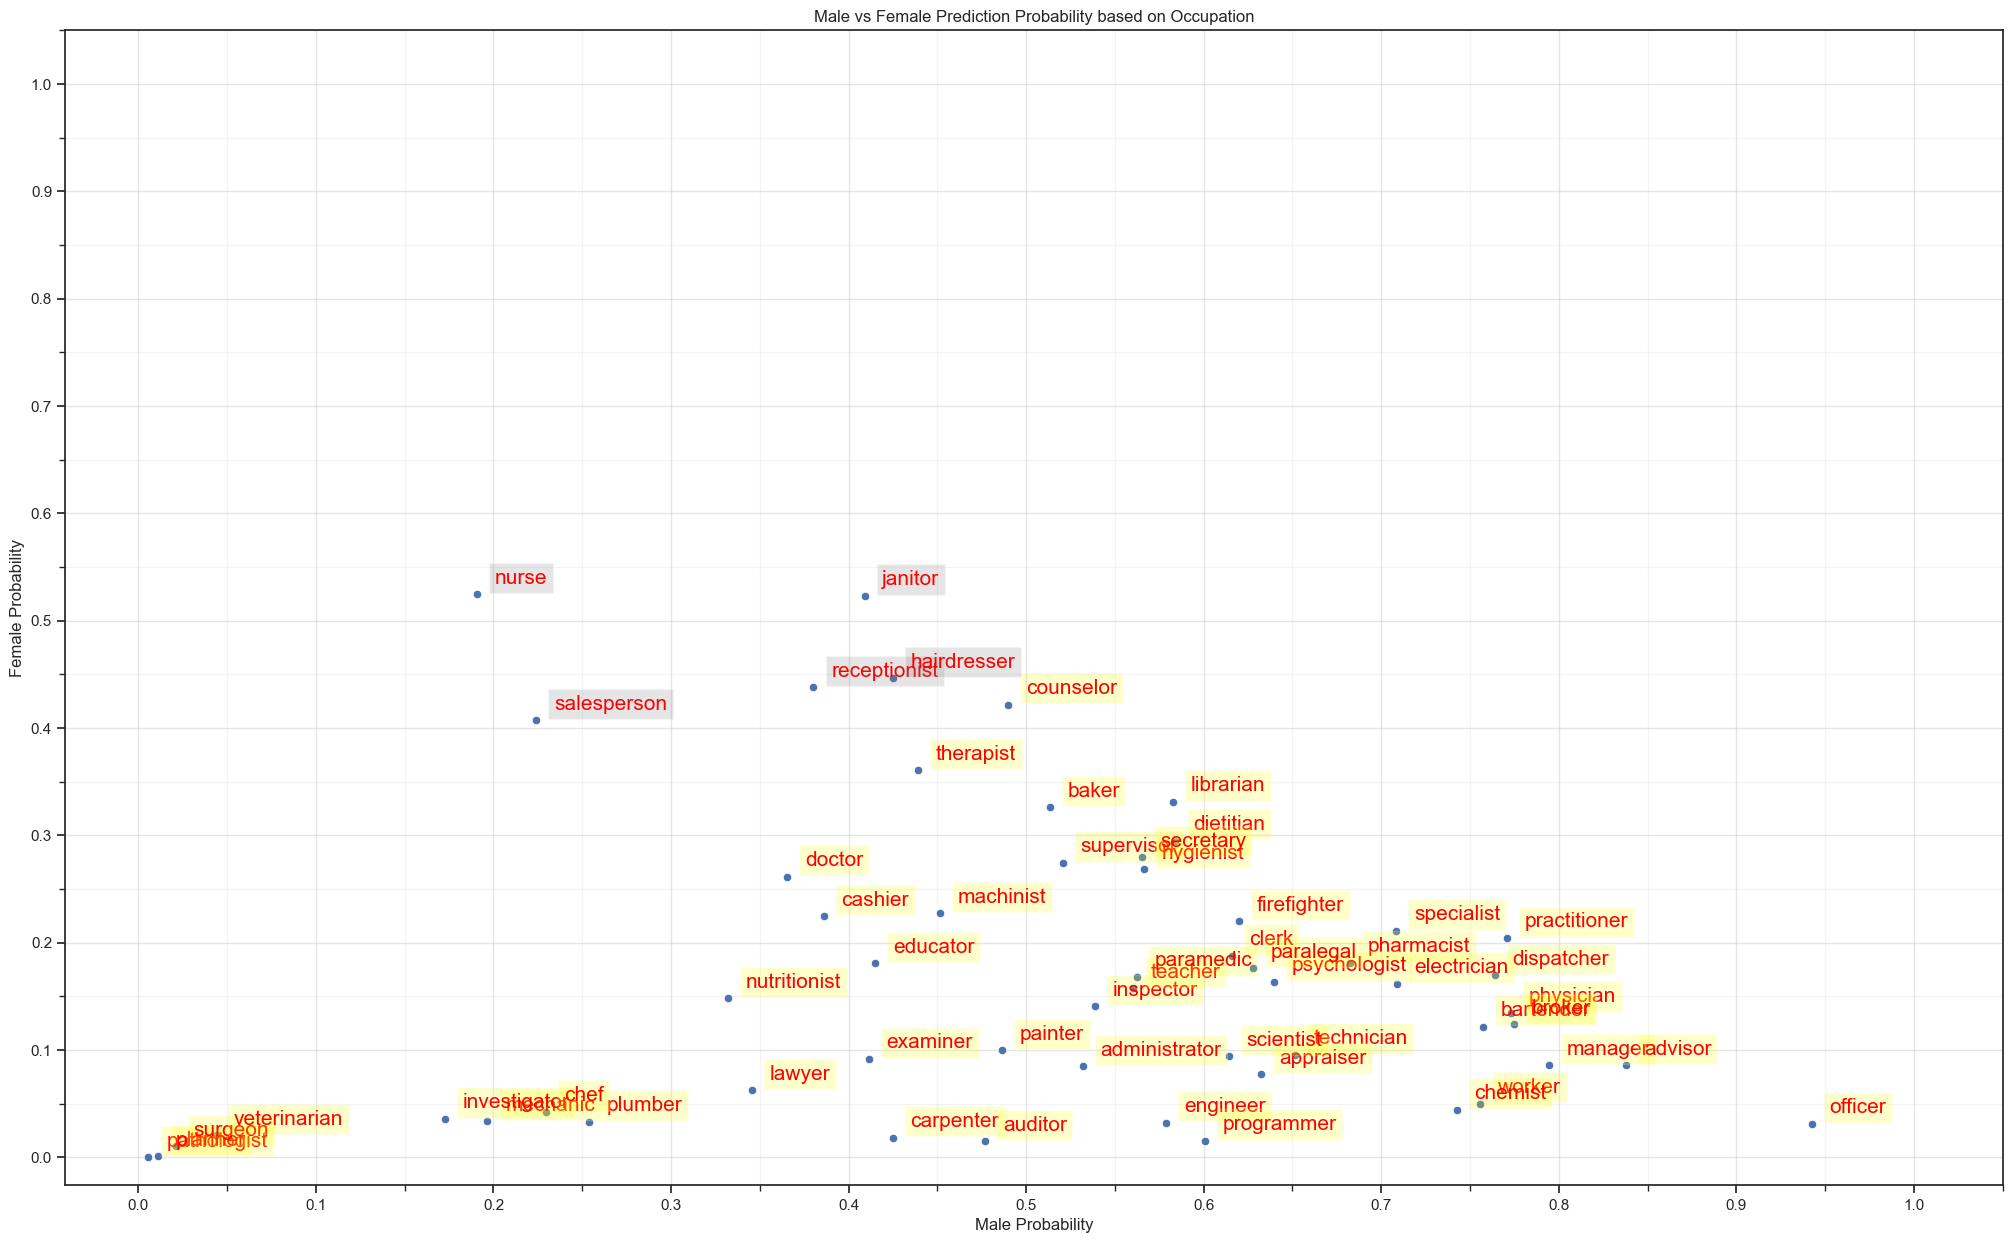

In [59]:
plt.figure(figsize=(25,15))
ax = sns.scatterplot(data=df_gender_quants,x='male_prob',y='female_prob')
sns.set(style="ticks")
for i in range(df_gender_quants.shape[0]):
    if df_gender_quants.male_prob[i] > df_gender_quants.female_prob[i]:
        txt_color = "red"
        bbox_color = "yellow"
    else:
        txt_color = "red"
        bbox_color = "grey"
        
    plt.text(x=df_gender_quants.male_prob[i]+0.01,
            y=df_gender_quants.female_prob[i]+0.01,
            s=df_gender_quants.occupation[i], 
            fontdict=dict(color=txt_color,size=15),
            bbox=dict(facecolor=bbox_color,alpha=0.2))
 
plt.title("Male vs Female Prediction Probability based on Occupation") 
plt.xlabel("Male Probability")                         
plt.ylabel("Female Probability") 

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1.1, 0.1)
minor_ticks = np.arange(0, 1.1, 0.05)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5) 

# plt.grid(True, axis="both", )                  

plt.show()

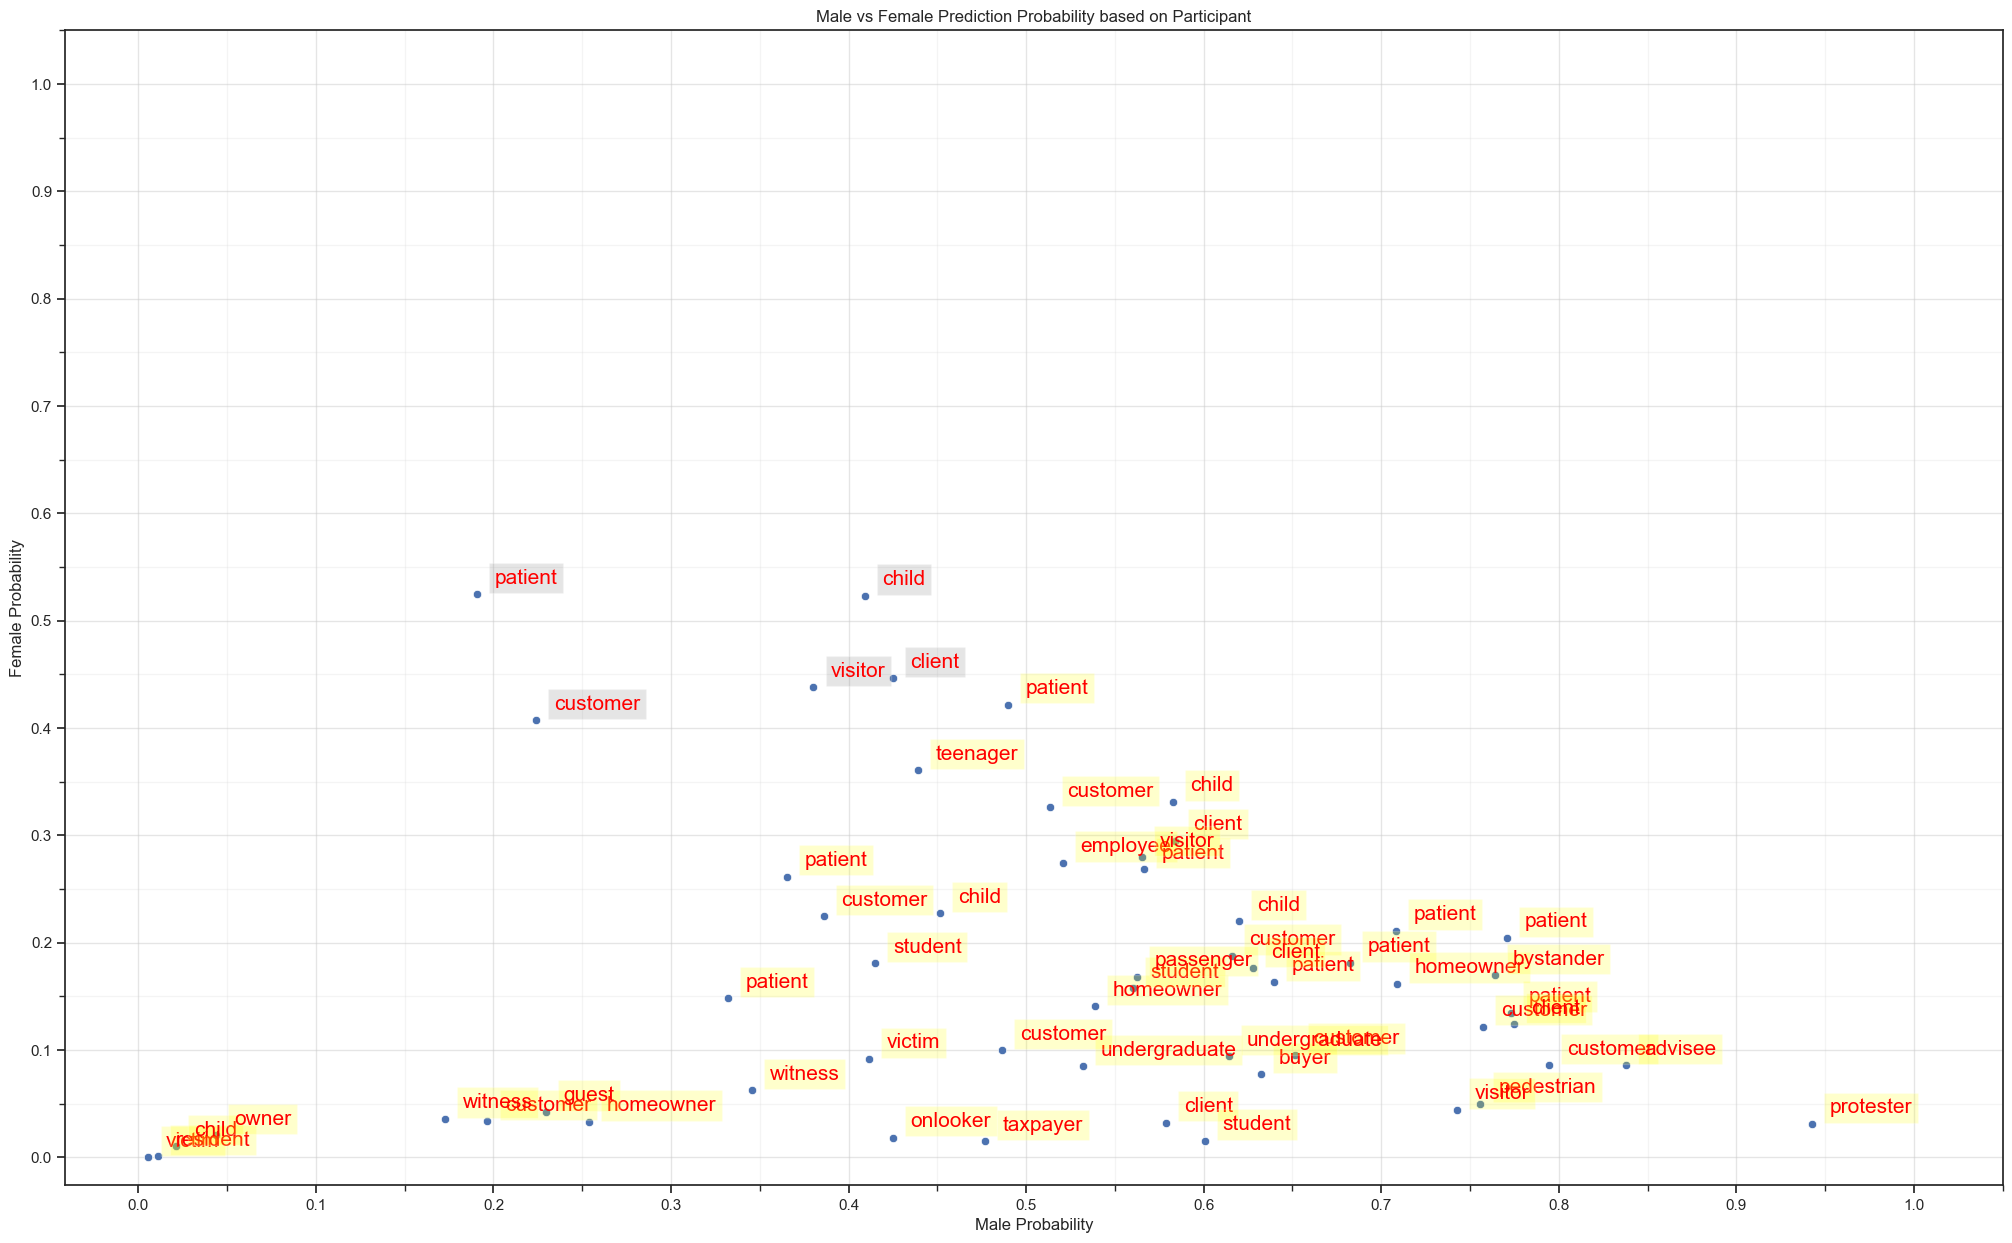

In [60]:
plt.figure(figsize=(25,15))
ax = sns.scatterplot(data=df_gender_quants,x='male_prob',y='female_prob')
sns.set(style="ticks")
for i in range(df_gender_quants.shape[0]):
    if df_gender_quants.male_prob[i] > df_gender_quants.female_prob[i]:
        txt_color = "red"
        bbox_color = "yellow"
    else:
        txt_color = "red"
        bbox_color = "grey"
        
    plt.text(x=df_gender_quants.male_prob[i]+0.01,
            y=df_gender_quants.female_prob[i]+0.01,
            s=df_gender_quants.participant[i], 
            fontdict=dict(color=txt_color,size=15),
            bbox=dict(facecolor=bbox_color,alpha=0.2))
 
plt.title("Male vs Female Prediction Probability based on Participant") 
plt.xlabel("Male Probability")                         
plt.ylabel("Female Probability") 

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1.1, 0.1)
minor_ticks = np.arange(0, 1.1, 0.05)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5) 

# plt.grid(True, axis="both", )                  

plt.show()

In [61]:
df.loc[df["occupation(0)"] == "surgeon"]

,occupation(0),other-participant(1),answer,sentence,masked_sentences,predictions,word_importances,probs,pred_words,tokens
35,surgeon,child,1,The $OCCUPATION operated on the $PARTICIPANT w...,The surgeon operated on the child with great c...,"{'probabilities': [[0.9480684399604797, 0.0212...","[0.003372605205407537, 0.045467206323361424, 0...","[0.9480684399604797, 0.0212135910987854, 0.010...","[the, his, her, its, a]","[[CLS], The, surgeon, operated, on, the, child..."


In [62]:
df_gender_quants.head(3)

,index,occupation,participant,male_pred,male_prob,male_word_imp,male_tokens,female_pred,female_prob,female_word_imp,female_tokens
0,0,technician,customer,he,0.651657,"[0.06173572934531598, 0.07724038119584334, 0.1...","[[SEP], that, customer, ., technician]",she,0.095750,"[0.06173572934531598, 0.07724038119584334, 0.1...","[[SEP], that, customer, ., technician]"
1,2,supervisor,employee,his,0.520671,"[0.10223976427573817, 0.11011257209765155, 0.1...","[supervisor, performance, the, [SEP], stellar]",her,0.274540,"[0.10223976427573817, 0.11011257209765155, 0.1...","[supervisor, performance, the, [SEP], stellar]"
2,3,engineer,client,he,0.578811,"[0.07307901272036241, 0.08859190870204606, 0.1...","[to, need, project, informed, client]",she,0.032507,"[0.07307901272036241, 0.08859190870204606, 0.1...","[to, need, project, informed, client]"


In [63]:
gender_pred, male_occ, female_occ = [], [], []
for i, row in df_gender_quants.iterrows():
    if row["male_prob"] > row["female_prob"]:
        gender_pred.append("male")
        male_occ.append(row["occupation"])
    else:
        gender_pred.append("female")
        female_occ.append(row["occupation"])
        
df_gender_quants["gender_pred"] = gender_pred

In [64]:
male_occ

['technician',
 'supervisor',
 'engineer',
 'worker',
 'educator',
 'clerk',
 'counselor',
 'inspector',
 'mechanic',
 'manager',
 'therapist',
 'administrator',
 'librarian',
 'advisor',
 'pharmacist',
 'psychologist',
 'physician',
 'carpenter',
 'investigator',
 'bartender',
 'specialist',
 'electrician',
 'officer',
 'pathologist',
 'teacher',
 'lawyer',
 'planner',
 'practitioner',
 'plumber',
 'surgeon',
 'veterinarian',
 'paramedic',
 'examiner',
 'chemist',
 'machinist',
 'appraiser',
 'nutritionist',
 'baker',
 'programmer',
 'paralegal',
 'hygienist',
 'scientist',
 'dispatcher',
 'cashier',
 'auditor',
 'dietitian',
 'painter',
 'broker',
 'chef',
 'doctor',
 'firefighter',
 'secretary']

In [65]:
female_occ

['salesperson', 'receptionist', 'janitor', 'nurse', 'hairdresser']

#### Wordcloud

In [66]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [67]:
_important_male_tokens, _important_female_tokens = [], []

for i, row in df_gender_quants.iterrows():
    if row["male_prob"] > row["female_prob"]:
        _important_male_tokens.append(row["male_tokens"])
    else:
        _important_female_tokens.append(row["female_tokens"])

important_male_tokens = list(np.hstack(_important_male_tokens))
important_male_text = " ".join(toks for toks in important_male_tokens).lower()
_important_male_word_freq = []  
for i in important_male_text.split(" "):
    word_count = important_male_text.count(i)
    _important_male_word_freq.append((i,word_count))       

important_male_word_freq = dict(_important_male_word_freq)

important_female_tokens = list(np.hstack(_important_female_tokens))
important_female_text = " ".join(toks for toks in important_female_tokens).lower()
_important_female_word_freq = []  
for i in important_female_text.split(" "):
    word_count = important_female_text.count(i)
    _important_female_word_freq.append((i,word_count))   
    
important_female_word_freq = dict(_important_female_word_freq)

In [68]:
important_female_word_freq

{'the': 7,
 'could': 1,
 '.': 2,
 'explain': 1,
 '##ist': 1,
 'if': 2,
 'needed': 1,
 'sign': 1,
 'hurt': 1,
 'not': 1,
 'child': 1,
 'ending': 1,
 'patient': 1,
 'shift': 1,
 'a': 4,
 'helpful': 1,
 'recommended': 1,
 'hair': 1}

In [69]:
important_male_tokens

['[SEP]',
 'that',
 'customer',
 '.',
 'technician',
 'supervisor',
 'performance',
 'the',
 '[SEP]',
 'stellar',
 'to',
 'need',
 'project',
 'informed',
 'client',
 'street',
 'should',
 'avoid',
 'pedestrian',
 'worker',
 'writing',
 'skills',
 'The',
 'student',
 'educator',
 'to',
 '[SEP]',
 'for',
 'the',
 'clerk',
 'certain',
 'disclosed',
 '[MASK]',
 'to',
 'patient',
 'The',
 'asked',
 '.',
 '##own',
 'house',
 '.',
 'customer',
 'mechanic',
 'ready',
 'that',
 'because',
 'to',
 'to',
 'able',
 'manager',
 'seemed',
 '##fi',
 'teenager',
 'The',
 'con',
 'organized',
 '[MASK]',
 'presented',
 '[SEP]',
 'that',
 '[SEP]',
 'the',
 'helped',
 'librarian',
 'child',
 'because',
 '##e',
 '[MASK]',
 'advise',
 'advice',
 'the',
 '##ma',
 'should',
 'told',
 'pills',
 'the',
 '##naire',
 'to',
 'preliminary',
 'psychologist',
 'needed',
 'rest',
 'patient',
 'warned',
 'physician',
 'thirty',
 'carpenter',
 'building',
 'feet',
 '.',
 'but',
 'investigator',
 '##ble',
 '##cha',
 'un

In [70]:
important_female_tokens

['the',
 'could',
 '.',
 'The',
 'explain',
 '##ist',
 'the',
 'if',
 'needed',
 'sign',
 'the',
 'The',
 'hurt',
 'not',
 'child',
 '.',
 'The',
 'ending',
 'patient',
 'shift',
 'a',
 'helpful',
 'recommended',
 'The',
 'hair']

In [71]:
stopwords = set(STOPWORDS)
# stopwords.update([".", "[SEP]", "[mask]", "SEP", "nan", "the", "to", "mask"])

In [72]:
word_cloud = WordCloud(
    background_color="white",
    min_word_length=0,
    stopwords=stopwords
)

In [73]:
important_male_word_freq

{'[sep]': 9,
 'that': 6,
 'customer': 4,
 '.': 16,
 'technician': 1,
 'supervisor': 1,
 'performance': 1,
 'the': 19,
 'stellar': 1,
 'to': 23,
 'need': 3,
 'project': 1,
 'informed': 2,
 'client': 3,
 'street': 1,
 'should': 2,
 'avoid': 1,
 'pedestrian': 1,
 'worker': 1,
 'writing': 1,
 'skills': 1,
 'student': 3,
 'educator': 1,
 'for': 6,
 'clerk': 1,
 'certain': 1,
 'disclosed': 1,
 '[mask]': 8,
 'patient': 5,
 'asked': 2,
 '##own': 2,
 'house': 2,
 'mechanic': 1,
 'ready': 1,
 'because': 4,
 'able': 2,
 'manager': 1,
 'seemed': 1,
 '##fi': 1,
 'teenager': 1,
 'con': 1,
 'organized': 1,
 'presented': 1,
 'helped': 1,
 'librarian': 1,
 'child': 2,
 '##e': 1,
 'advise': 1,
 'advice': 1,
 '##ma': 1,
 'told': 3,
 'pills': 1,
 '##naire': 1,
 'preliminary': 1,
 'psychologist': 1,
 'needed': 2,
 'rest': 1,
 'warned': 1,
 'physician': 1,
 'thirty': 1,
 'carpenter': 1,
 'building': 1,
 'feet': 1,
 'but': 1,
 'investigator': 1,
 '##ble': 1,
 '##cha': 1,
 'un': 8,
 'feeling': 1,
 'generous':

##### Word Cloud using Frequency

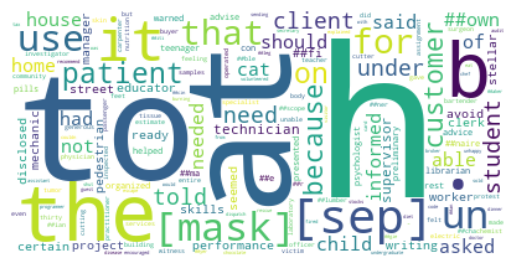

In [74]:
word_cloud = word_cloud.generate_from_frequencies(important_male_word_freq)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

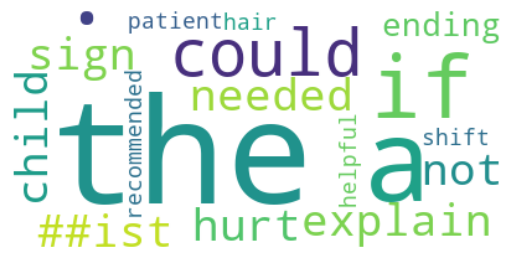

In [75]:
word_cloud = word_cloud.generate_from_frequencies(important_female_word_freq)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### Word Cloud without Frequency (Relative Scaling)

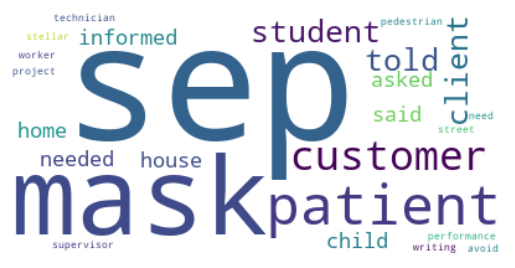

In [93]:
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white", 
                      relative_scaling=1, 
                      max_words = 25).generate(important_male_text) # Remove max_words to include all words

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

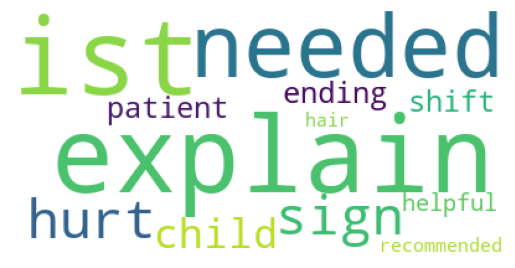

In [77]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(important_female_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##### Word Cloud using TF-IDF

In [134]:
# _important_male_tokens

In [108]:
_important_male_tokens_text, _important_female_tokens_text = [], []

for i, row in enumerate(_important_male_tokens):
    _important_male_tokens_text.append(" ".join(row).lower())

for i, row in enumerate(_important_female_tokens):
    _important_female_tokens_text.append(" ".join(row).lower())

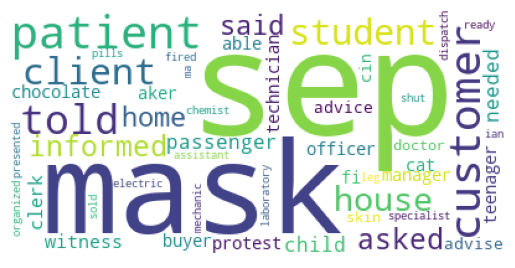

In [137]:
vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(_important_male_tokens_text)
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
_df_male = pd.DataFrame(lst1, columns=feature_names)

male_tfidf_cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(_df_male.T.sum(axis=1))
plt.imshow(male_tfidf_cloud)
plt.axis("off")
plt.show()

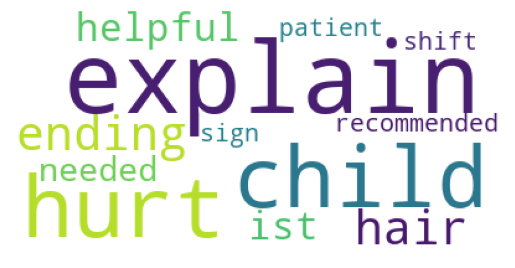

In [133]:
vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(_important_female_tokens_text)
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
_df_female = pd.DataFrame(lst1, columns=feature_names)

female_tfidf_cloud = WordCloud(background_color="white").generate_from_frequencies(_df_female.T.sum(axis=1))
plt.imshow(female_tfidf_cloud)
plt.axis("off")
plt.show()

#### How important is occupation?

In [78]:
df_gender_quants = pd.read_csv("df_gender_quants_5.csv")
df_gender_quants.drop(columns=["index"], inplace=True)

In [79]:
df_gender_quants.head(15)

,occupation,participant,male_pred,male_prob,male_word_imp,male_tokens,female_pred,female_prob,female_word_imp,female_tokens
0,technician,customer,he,0.651657,"[0.06173572934531598, 0.07724038119584334, 0.1...","['[SEP]', 'that', 'customer', '.', 'technician']",she,0.095750,"[0.06173572934531598, 0.07724038119584334, 0.1...","['[SEP]', 'that', 'customer', '.', 'technician']"
1,supervisor,employee,his,0.520671,"[0.10223976427573817, 0.11011257209765155, 0.1...","['supervisor', 'performance', 'the', '[SEP]', ...",her,0.274540,"[0.10223976427573817, 0.11011257209765155, 0.1...","['supervisor', 'performance', 'the', '[SEP]', ..."
2,engineer,client,he,0.578811,"[0.07307901272036241, 0.08859190870204606, 0.1...","['to', 'need', 'project', 'informed', 'client']",she,0.032507,"[0.07307901272036241, 0.08859190870204606, 0.1...","['to', 'need', 'project', 'informed', 'client']"
3,worker,pedestrian,he,0.755837,"[0.07843126098134591, 0.07961902098003028, 0.1...","['street', 'should', 'avoid', 'pedestrian', 'w...",she,0.050235,"[0.07843126098134591, 0.07961902098003028, 0.1...","['street', 'should', 'avoid', 'pedestrian', 'w..."
4,educator,student,his,0.415021,"[0.08478334923829477, 0.11937091601649565, 0.1...","['writing', 'skills', 'The', 'student', 'educa...",her,0.180842,"[0.08478334923829477, 0.11937091601649565, 0.1...","['writing', 'skills', 'The', 'student', 'educa..."
5,clerk,customer,him,0.615757,"[0.08079321750350617, 0.08555914784289045, 0.1...","['to', '[SEP]', 'for', 'the', 'clerk']",her,0.187992,"[0.08079321750350617, 0.08555914784289045, 0.1...","['to', '[SEP]', 'for', 'the', 'clerk']"
6,counselor,patient,he,0.489855,"[0.07678320848167608, 0.07743946199804375, 0.0...","['certain', 'disclosed', '[MASK]', 'to', 'pati...",she,0.421876,"[0.07678320848167608, 0.07743946199804375, 0.0...","['certain', 'disclosed', '[MASK]', 'to', 'pati..."
7,inspector,homeowner,he,0.538850,"[0.06957579691331314, 0.11679468564193791, 0.1...","['The', 'asked', '.', '##own', 'house']",she,0.140811,"[0.06957579691331314, 0.11679468564193791, 0.1...","['The', 'asked', '.', '##own', 'house']"
8,mechanic,customer,his,0.196612,"[0.07514716019448114, 0.08192640110555031, 0.1...","['.', 'customer', 'mechanic', 'ready', 'that']",her,0.033621,"[0.07514716019448114, 0.08192640110555031, 0.1...","['.', 'customer', 'mechanic', 'ready', 'that']"
9,manager,customer,he,0.794464,"[0.07545660848735719, 0.07596007143444905, 0.0...","['because', 'to', 'to', 'able', 'manager']",she,0.085705,"[0.07545660848735719, 0.07596007143444905, 0.0...","['because', 'to', 'to', 'able', 'manager']"


In [85]:
occupation_in_wip = []
for i, row in df_gender_quants.iterrows():
    if row["occupation"] in row["male_tokens"]:
        print(row["occupation"])
        occupation_in_wip.append(row["occupation"])
        
len(occupation_in_wip)

technician
supervisor
worker
educator
clerk
mechanic
manager
librarian
psychologist
physician
carpenter
investigator
bartender
specialist
officer
teacher
practitioner
surgeon
chemist
programmer
broker
chef
doctor
secretary


24

In [81]:
# Percentage of Occupation bias in predictions
len(occupation_in_wip)/df_gender_quants.shape[0]*100.2

42.189473684210526

In [88]:
participant_in_wip = []
for i, row in df_gender_quants.iterrows():
    if row["participant"] in row["male_tokens"]:
        print(row["participant"])
        participant_in_wip.append(row["participant"])
        
len(participant_in_wip)

customer
client
pedestrian
student
patient
customer
teenager
child
child
patient
patient
customer
patient
student
witness
patient
passenger
victim
child
buyer
student
client
patient
undergraduate
customer
client
visitor


27

In [84]:
# Percentage of Occupation bias in predictions
len(participant_in_wip)/df_gender_quants.shape[0]*100.2

47.46315789473684